In [1]:
from numpy import array, float32
from pandas import DataFrame
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier


from neuralzoo.model.cnn import create_cnn
from neuralzoo.selector.random_selection import get_random_image_per_class
from neuralzoo.transformer.one_hot_encoder import one_encode_labels
from neuralzoo.visualization.image_loader import load_image, dataframe_per_labels
# from neuralzoo.visualization.metrics import show_performance



In [2]:
# NOTE legacy import from local pickles
# dataframe_train, target_train, dataframe_test, target_test = dataframes_from_cifar()
# target_train.head()
data = tf.keras.datasets.cifar10.load_data()

In [3]:
(dataframe_train, target_train), (dataframe_test, target_test) = data 
full_dataframe_train = DataFrame(data = {'image':[element for element in dataframe_train], 'label':[element[0] for element in target_train]})
full_dataframe_test = DataFrame(data = {'image':[element for element in dataframe_test], 'label':[element[0] for element in target_test]})

Image 0 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 1 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 2 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 3 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 4 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 5 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 6 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 7 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 8 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 9 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)


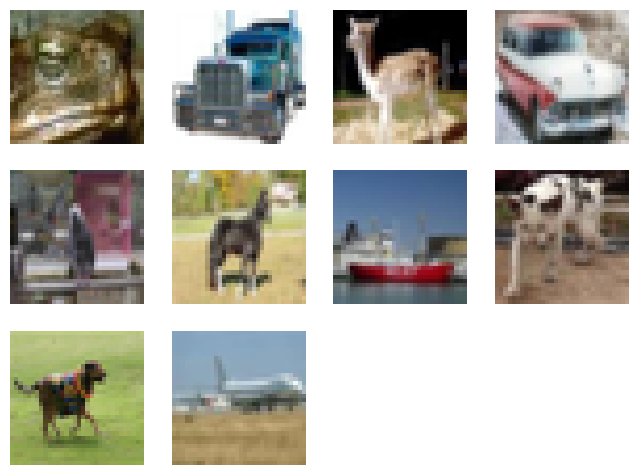

In [4]:
images = get_random_image_per_class(full_dataframe_train)
load_image(images)


In [5]:
full_dataframe_train['label'].value_counts()

label
6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: count, dtype: int64

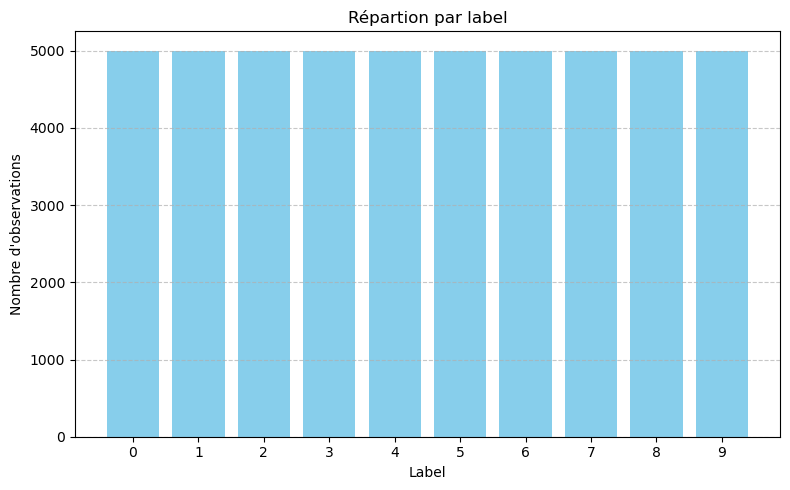

In [6]:
dataframe_per_labels(full_dataframe_train)

In [7]:
UNWANTED_LABELS = [0,1,8,9]
full_dataframe_train = full_dataframe_train[~full_dataframe_train['label'].isin(UNWANTED_LABELS)]
full_dataframe_train.reset_index(drop=True, inplace=True)

full_dataframe_test = full_dataframe_test[~full_dataframe_test['label'].isin(UNWANTED_LABELS)]
full_dataframe_test.reset_index(drop=True, inplace=True)


Image 0 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 1 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 2 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 3 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 4 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)
Image 5 type: <class 'numpy.ndarray'>, shape: (32, 32, 3)


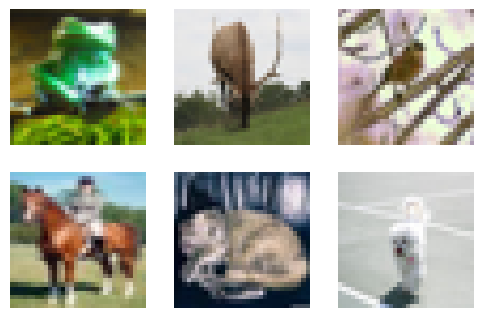

In [8]:
images = get_random_image_per_class(full_dataframe_train)
load_image(images)

In [9]:
#ONE HOT ENCODE LABELS
full_dataframe_train = one_encode_labels(full_dataframe_train, True)
full_dataframe_test = one_encode_labels(full_dataframe_test, True)
full_dataframe_train

,image,label_is_bird,label_is_cat,label_is_deer,label_is_dog,label_is_frog,label_is_horse
0,"[[[59, 62, 63], [43, 46, 45], [50, 48, 43], [6...",0.0,1.0,0.0,0.0,0.0,0.0
1,"[[[28, 25, 10], [37, 34, 19], [38, 35, 20], [4...",1.0,0.0,0.0,0.0,0.0,0.0
2,"[[[164, 206, 84], [105, 140, 61], [118, 148, 1...",0.0,0.0,0.0,0.0,1.0,0.0
3,"[[[28, 35, 39], [30, 34, 44], [33, 44, 47], [6...",0.0,0.0,0.0,1.0,0.0,0.0
4,"[[[125, 125, 116], [110, 101, 91], [102, 90, 8...",0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
29995,"[[[161, 166, 159], [172, 177, 170], [176, 181,...",0.0,0.0,0.0,0.0,0.0,1.0
29996,"[[[226, 229, 235], [226, 229, 237], [231, 235,...",1.0,0.0,0.0,0.0,0.0,0.0
29997,"[[[188, 195, 201], [186, 193, 200], [187, 194,...",0.0,0.0,0.0,0.0,1.0,0.0
29998,"[[[145, 161, 194], [151, 166, 199], [156, 171,...",0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
model = create_cnn()
images_train, labels_train = full_dataframe_train['image'], full_dataframe_train.drop(columns=['image'])
images_test, labels_test = full_dataframe_test['image'], full_dataframe_test.drop(columns=['image'])

images_train = array(images_train.tolist(), dtype=float32) / 255.0
images_test = array(images_test.tolist(), dtype=float32) / 255.0

BATCH_SIZE = 32
EPOCHS = 6

training_history = model.fit(images_train, labels_train,
                	epochs=EPOCHS, batch_size=BATCH_SIZE,
                	validation_data=(images_test, labels_test))

Epoch 1/6
938/938 [==============================] - 76s 80ms/step - loss: 1.6985 - accuracy: 0.2692 - val_loss: 1.5292 - val_accuracy: 0.3768
Epoch 2/6
938/938 [==============================] - 49s 52ms/step - loss: 1.4917 - accuracy: 0.3920 - val_loss: 1.4131 - val_accuracy: 0.4443
Epoch 3/6
938/938 [==============================] - 47s 50ms/step - loss: 1.4101 - accuracy: 0.4354 - val_loss: 1.3594 - val_accuracy: 0.4668
Epoch 4/6
938/938 [==============================] - 48s 51ms/step - loss: 1.3492 - accuracy: 0.4684 - val_loss: 1.3165 - val_accuracy: 0.4822
Epoch 5/6
938/938 [==============================] - 48s 51ms/step - loss: 1.2912 - accuracy: 0.4975 - val_loss: 1.2647 - val_accuracy: 0.5062
Epoch 6/6
938/938 [==============================] - 47s 50ms/step - loss: 1.2417 - accuracy: 0.5174 - val_loss: 1.2279 - val_accuracy: 0.5225


In [14]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        12832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                    

Text(0.5, 1.0, 'Accuracy by epochs')

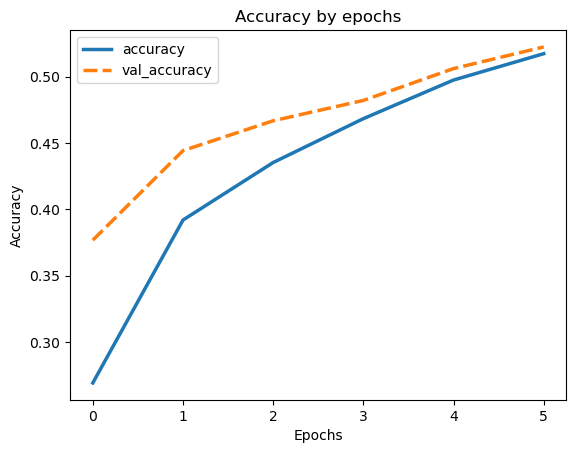

In [15]:
from seaborn import lineplot
df_history = DataFrame(training_history.history)
plot = lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5)
plot.set_xlabel('Epochs')
plot.set_ylabel('Accuracy')
plot.set_title('Accuracy by epochs')

In [ ]:
# plot = lineplot(data=df_history[['precision','val_precision']], palette="tab10", linewidth=2.5)
# plot.set_xlabel('Epochs')
# plot.set_ylabel('Precision')
# plot.set_title('Precision by epochs')

KeyError: "None of [Index(['precision', 'val_precision'], dtype='object')] are in the [columns]"

Text(0.5, 1.0, 'Recall by epochs')

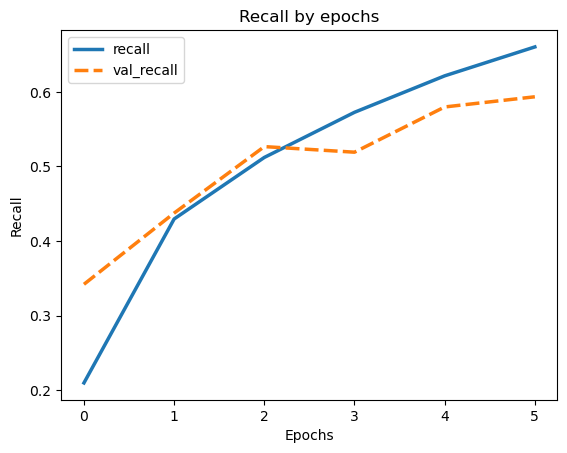

In [ ]:
# plot = lineplot(data=df_history[['recall','val_recall']], palette="tab10", linewidth=2.5)
# plot.set_xlabel('Epochs')
# plot.set_ylabel('Recall')
# plot.set_title('Recall by epochs')

In [16]:
model = KerasClassifier(build_fn=create_cnn, verbose=1)
# define parameters and values for grid search 
param_grid = param_grid = {
    'pool_type': ['max', 'average'],
    'conv_activation': ['sigmoid', 'tanh'],    
    'epochs': [8],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(images_train, labels_train)

C:\Users\cleme\AppData\Local\Temp\ipykernel_15492\2803235416.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, verbose=1)


Epoch 1/8
938/938 [==============================] - 74s 76ms/step - loss: 1.4474 - accuracy: 0.4211
Epoch 2/8
938/938 [==============================] - 78s 83ms/step - loss: 1.2172 - accuracy: 0.5317
Epoch 3/8
938/938 [==============================] - 76s 81ms/step - loss: 1.1053 - accuracy: 0.5786
Epoch 4/8
938/938 [==============================] - 79s 84ms/step - loss: 1.0225 - accuracy: 0.6152
Epoch 5/8
938/938 [==============================] - 74s 79ms/step - loss: 0.9636 - accuracy: 0.6384
Epoch 6/8
938/938 [==============================] - 76s 81ms/step - loss: 0.9060 - accuracy: 0.6643
Epoch 7/8
938/938 [==============================] - 72s 77ms/step - loss: 0.8639 - accuracy: 0.6786
Epoch 8/8
938/938 [==============================] - 74s 79ms/step - loss: 0.8212 - accuracy: 0.6953


In [17]:
cnn = grid_result.best_estimator_
history = cnn.fit(
    images_train,
    labels_train,
    validation_data = (images_test, labels_test),
    epochs = 10,
)

Epoch 1/10
938/938 [==============================] - 80s 85ms/step - loss: 1.4697 - accuracy: 0.4085 - val_loss: 1.2771 - val_accuracy: 0.5070
Epoch 2/10
938/938 [==============================] - 80s 85ms/step - loss: 1.2238 - accuracy: 0.5285 - val_loss: 1.1915 - val_accuracy: 0.5463
Epoch 3/10
938/938 [==============================] - 78s 83ms/step - loss: 1.1096 - accuracy: 0.5815 - val_loss: 1.1008 - val_accuracy: 0.5893
Epoch 4/10
938/938 [==============================] - 79s 84ms/step - loss: 1.0297 - accuracy: 0.6106 - val_loss: 1.0503 - val_accuracy: 0.6085
Epoch 5/10
938/938 [==============================] - 82s 88ms/step - loss: 0.9697 - accuracy: 0.6376 - val_loss: 1.0481 - val_accuracy: 0.6058
Epoch 6/10
938/938 [==============================] - 82s 87ms/step - loss: 0.9171 - accuracy: 0.6614 - val_loss: 0.9982 - val_accuracy: 0.6263
Epoch 7/10
938/938 [==============================] - 78s 84ms/step - loss: 0.8695 - accuracy: 0.6780 - val_loss: 0.9865 - val_accuracy:

Text(0.5, 1.0, 'Accuracy by epochs')

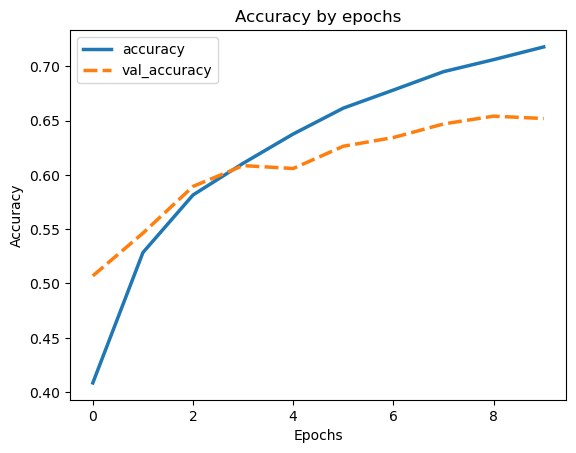

In [18]:

df_history = DataFrame(history.history)
plot = lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5)
plot.set_xlabel('Epochs')
plot.set_ylabel('Accuracy')
plot.set_title('Accuracy by epochs')

188/188 [==============================] - 1s 5ms/step
[2 1 1 ... 5 5 3]


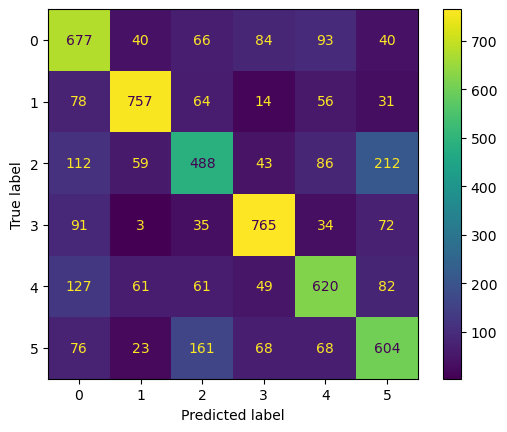

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from numpy import argmax
from matplotlib.pyplot import show

test_predictions = cnn.predict(images_test)


test_true_labels = argmax(labels_test, axis=1)
print(test_predictions)

cm = confusion_matrix(test_true_labels, test_predictions)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
show()

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

print(f"La matrice de confusion : {confusion_matrix(test_true_labels, test_predictions)}")
print(f"La moyenne est : {accuracy_score(test_true_labels, test_predictions)}")
print(f"La précision par label: {precision_score(test_true_labels, test_predictions, average=None)}")
print(f"La sensibilité par label : {recall_score(test_true_labels, test_predictions, average=None)}")
print(f"La moyenne harmonique par label : {f1_score(test_true_labels, test_predictions, average=None)}")

La matrice de confusion : [[677  40  66  84  93  40]
 [ 78 757  64  14  56  31]
 [112  59 488  43  86 212]
 [ 91   3  35 765  34  72]
 [127  61  61  49 620  82]
 [ 76  23 161  68  68 604]]
La moyenne par label : 0.6518333333333334
La précision par label: [0.583118   0.80275716 0.55771429 0.74780059 0.64785789 0.58021134]
La sensibilité par label : [0.677 0.757 0.488 0.765 0.62  0.604]
La moyenne harmonique par label : [0.62656178 0.77920741 0.52053333 0.75630252 0.63362289 0.59186673]
